In [1]:
import numpy as np
import h5py
from astropy.io import fits
from skimage.transform import resize
from multiprocessing import Pool
from pathlib import Path
from scipy.ndimage import rotate 
from math import pi

import matplotlib.pyplot as plt

In [5]:
INPUT_DIR = "D:/Users/Paul/Downloads/COSMOS_235_training/COSMOS_235_training_sample/"
OUT_NAME = "C:/Users/Paul/Research/COSMOS_NO-ALIGN" #no .hdf5 at the end

CROP_RATIO = 0.8 #retain 80% of image
INTERPOLATION_ORDER = 3 #interpolation order on resize and align
FINAL_SIZE = (64,64) #final size for all images
ALIGN = False #to align all major axes with x axis
MIN_SIZE = 32 #minimum number of x pixels in original image; setting this to 32 cuts 87 images from the dataset.
DISCARD_INV_SERS = True #discard galaxies that don't match sersic fit
CHUNK_SIZE = 512

#Note that for MIN_SIZE set too small, it will not work at all (specifically it will _at least_ fail for one image that is 10x9)

Saves as HDF5 dataset. Format:
outfile/galaxy_data

structure: 
images: [N, img_x, img_y]
catalog: [N x [noise mean, noise variance, I, R_1/2, n, q, boxiness, x_0, y_0, phi]]

Images are cropped to central (CROP_RATIO) part of the original, then rotate to align major axis with the x-axis (ALIGN), then scaled up or further cropped to 

Note: images are already rotated to align major axis with the x-axis, so for all images phi should be ignored and one should instead always use phi = 0.

get full training set data from here: http://great3.jb.man.ac.uk/leaderboard/data
set INPUT_DIR to file where you've put the COSMOS data (see the example above). 
Datasets are saved to the directory this notebook is in.

Since we crop a bit off the images and mean and median of the dataset are at 110 and 90 respectively, I've set the default final size to 64x64 pixels. (as 0.8 * 90 = 72, and this leaves a little wiggle room for all the really small images (of size ~40)

In [6]:
class galdata_setup():
    """ class for extracting galaxy dataset from COSMOS data folder as a single hdf5 file. """
    
    def _crop_resize(self, image_array, crop_ratio=CROP_RATIO, rescale_size=FINAL_SIZE, 
                     int_order=INTERPOLATION_ORDER, min_size=MIN_SIZE):
        """ function for doing both cropping and resizing on a single image """
        assert np.ndim(image_array) == 2, "ERROR: _crop_img function: image is not 2D!"
        img_dims = np.shape(image_array)[0]
        if img_dims >= min_size:
            #crop to center part of image, cutting off (crop_ratio / 2) on all sides
            crop_cut = int(((1. - crop_ratio) / 2.)*img_dims)
            if crop_cut == 0:
                crop_cut = 1 #to prevent mega crash, skip first pixel only
            return resize(image_array[crop_cut:-crop_cut][crop_cut:-crop_cut], rescale_size, order=int_order, preserve_range=True)
        else:
                return np.zeros(rescale_size) #return zero-filled array if image too small
    
    def _crop_align_resize(self, image_array, sersicdata, id_batch, crop_ratio=CROP_RATIO, 
                               rescale_size=FINAL_SIZE, int_order=INTERPOLATION_ORDER, min_size=MIN_SIZE):
        """ Single image as input. Crops around center of image, then aligns with x axis, then resizes. 
        
        N.B.: not centering around x_0, y_0, as these seem to lie outside of the picture for most images?
        Find out why this is?
        """
        assert np.ndim(image_array) == 2, "ERROR: _crop_img function: image is not 2D!"
        try:
            img_dims = np.shape(image_array)[0]
            if img_dims >= min_size:
                crop_cut = int(((1. - crop_ratio) / 2.)*img_dims)
                if crop_cut == 0:
                    crop_cut = 1 #to prevent mega crash, skip first pixel only
                cropped = image_array[crop_cut:-crop_cut, crop_cut:-crop_cut]
                aligned = rotate(cropped, sersicdata[id_batch][7]*180./pi, order=int_order, mode='reflect', reshape=False)
                resized = resize(aligned, rescale_size, order=int_order, preserve_range=True, anti_aliasing=(rescale_size[0]<img_dims))
                return resized
            else:
                return np.zeros(rescale_size) #return zero-filled array if image too small
        except:
            print("well, things a-sploded.")
            print(np.shape(image_array))
            print(sersicdata[id_batch])
            plt.imshow(image_array)
            plt.title('base img')
            plt.show()
    
    def __init__(self, input_dir, outfile=".\galaxy_dataset", max_entries = 0, crop_ratio=CROP_RATIO, 
                 rescale_size=FINAL_SIZE, int_order=INTERPOLATION_ORDER, align=ALIGN, min_size=MIN_SIZE,
                 discard_inv_sersic=DISCARD_INV_SERS, chunk_size=CHUNK_SIZE, verbose=False):
        """
        Load data from fits files in given directory and save as single workable dataset file.

        Args:
            self.input_dir: input directory. String.
            outfile : name to give to the .hdf5 file when saving. String.
            max_entries : needed to specify size of .hdf5 database. If left 0, will pre-compute size of dataset. Int.
            rescale_size : galaxy images may be of any (2D) size; they will be rescaled to the shape specified here using 
                            interpolation. Tuple, shape (X, Y)
            int_order : interpolation order to use when resizing. Integer, range [0,5]
            crop_ratio : ratio of image to crop to BEFORE RESCALING; 1.0 retains entire image, 0.25 crops to 25% of original, 
                            etc. Float, range [0,1].
            verbose : more verbose output. Bool.
        Returns:
            N/A - writes to file. 
        """   
        self.input_dir = Path(input_dir)
        out_file = outfile+".hdf5"
        with h5py.File(out_file, "a") as hf_all:
            init = False
            count=0
            
            #open catalogues
            with fits.open(self.input_dir.joinpath('real_galaxy_catalog_23.5.fits')) as cat1, \
                fits.open(self.input_dir.joinpath('real_galaxy_catalog_23.5_fits.fits')) as cat2:
                
                #find length of dataset if unspecified
                if max_entries == 0:
                    max_entries = len(cat1[1].data)
                    print("max_entries from catalogue: {}".format(max_entries))
                else: print("max entries from arguments: {}".format(max_entries))
                
                gal_files = list(dict.fromkeys(cat1[1].data['gal_filename']))
                print("Initialising dataset... \n{} .FITS files found, commence reading....\n".format(len(gal_files)))
                
                #add data from files to dataset
                tracker = 0
                failed_sersic_tracker = 0
                for file_name in gal_files:
                    fullpath = self.input_dir.joinpath(file_name)
                    if verbose:
                        print("reading: {}".format(file_name))
                    with fits.open(fullpath) as hdul:
                        N = len(hdul)
                        # shape: [ N x 10]
                        sersicdata = np.array(cat2[1].data[tracker:tracker+N]['sersicfit'], dtype=float)
                        catdata = np.array([cat1[1].data[tracker:tracker+N]['noise_mean'], 
                                            cat1[1].data[tracker:tracker+N]['noise_variance'],
                                            cat2[1].data[tracker:tracker+N]['zphot'],
                                            cat2[1].data[tracker:tracker+N]['viable_sersic']]).T
                        
                        #rotation if necessary, otherwise just crop and resize.
                        if align: 
                            imdata = np.array([self._crop_align_resize(hdul[i].data, sersicdata, id_batch=i, 
                                                                       crop_ratio=crop_ratio, rescale_size=rescale_size, 
                                                                       int_order=int_order, min_size=min_size) 
                                               for i in range(len(hdul))])
                        else:
                            imdata = np.array([self._crop_resize(x.data, crop_ratio=crop_ratio, rescale_size=rescale_size, 
                                                                 int_order=int_order) for x in hdul])
                        
                        #clean up for unwanted data
                        
                        mask = np.not_equal(imdata, np.zeros(rescale_size)).all(axis=1).all(axis=1)
                        
                        if discard_inv_sersic: #if stripping invalid sersic images
                            mask2 = catdata[:,3]
                            mask_tot = (mask * mask2).astype(bool)
                            if 0. in mask2:
                                failed_sersic_tracker += int(mask2.shape[0] - np.sum(mask2))
                                print(f'Failed Sersic fit found! total: {failed_sersic_tracker}')
                        else:
                            mask_tot = mask

#                         print(mask_tot.shape)
#                         print(sersicdata.shape, catdata.shape, imdata.shape)
                        
                        sersicdata = sersicdata[mask_tot]
                        catdata = catdata[mask_tot]
                        imdata = imdata[mask_tot]
                        
#                         print(sersicdata.shape, catdata.shape, imdata.shape)
                        
                        #create processed dictionary with all the stuff
                        processed = {"images": imdata[:],
                                     "noise_mean": catdata[:,0],
                                     "noise_variance": catdata[:,1],
                                     "I_e": sersicdata[:,0],
                                     "r_e": sersicdata[:,1],
                                     "index": sersicdata[:,2],
                                     "q": sersicdata[:,3],
                                     "z": catdata[:,2]
                                    }
                        if not align:
                            processed["phi"] = sersicdata[:,7]
                        
#                         for k,v in processed.items():
#                             print(f"Array shape for {k}: {v.shape}")

                        
                        if init:  
                            if verbose:
                                print("images included: {}/{}".format(imdata.shape[0], N))
                            for k,v in processed.items():
                                hf_all[k].resize((hf_all[k].shape[0] + imdata.shape[0]), axis = 0)
                                hf_all[k][-imdata.shape[0]:] = v
                        else:
                            if verbose: 
                                print("images included: {}/{}".format(imdata.shape[0], N))
                            if chunk_size>0: #if chunking enabled
                                for k,v in processed.items():
                                    maxim_shape = list(v.shape)
                                    maxim_shape[0] = max_entries
                                    maxim_shape = tuple(maxim_shape)
                                    chunk_shape = list(v.shape)
                                    chunk_shape[0] = chunk_size
                                    chunk_shape = tuple(chunk_shape)
                                    dset_img = hf_all.create_dataset(k, data=v, maxshape=maxim_shape, chunks=chunk_shape)
                            else: #if chunking disabled
                                for k,v in processed.items():
                                    maxim_shape = list(v.shape)
                                    maxim_shape[0] = max_entries
                                    dset_img = hf_all.create_dataset(k, data=v, maxshape=maxim_shape)
                            init=True
                        
                        tracker += N
             
            print("Finished reading .FITS files.\n")
            print("Final database shapes:")
            for k, v in hf_all.items():
                print(f"\tArray shape for {k}: {v.shape}")
            if chunk_size >0:
                print(f"All were chunked, with chunksize = {chunk_size}")
            print(f"File saved as: {out_file}")

In [7]:
g = galdata_setup(input_dir=INPUT_DIR, outfile=OUT_NAME, verbose=True)
# note: you will get some userwarnings from skimage, this is normal and expected.
# execution should take 3 to 5 minutes.

max_entries from catalogue: 56062
Initialising dataset... 
57 .FITS files found, commence reading....

reading: real_galaxy_images_23.5_n1.fits


D:\Users\Paul\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images included: 997/1000
reading: real_galaxy_images_23.5_n2.fits
images included: 998/1000
reading: real_galaxy_images_23.5_n3.fits
images included: 998/1000
reading: real_galaxy_images_23.5_n4.fits
images included: 999/1000
reading: real_galaxy_images_23.5_n5.fits
images included: 999/1000
reading: real_galaxy_images_23.5_n6.fits
images included: 999/1000
reading: real_galaxy_images_23.5_n7.fits
Failed Sersic fit found! total: 1
images included: 999/1000
reading: real_galaxy_images_23.5_n8.fits
images included: 1000/1000
reading: real_galaxy_images_23.5_n9.fits
Failed Sersic fit found! total: 2
images included: 997/1000
reading: real_galaxy_images_23.5_n10.fits
images included: 998/1000
reading: real_galaxy_images_23.5_n11.fits
images included: 998/1000
reading: real_galaxy_images_23.5_n12.fits
Failed Sersic fit found! total: 3
images included: 996/1000
reading: real_galaxy_images_23.5_n13.fits
images included: 999/1000
reading: real_galaxy_images_23.5_n14.fits
images included: 998/

In [28]:
## some misc code for testing purposes. feel free to ignore.

input_dir="D:/Users/Paul/Downloads/COSMOS_235_training/COSMOS_235_training_sample/"
input_dir = Path(input_dir) 
for file_name in os.listdir(str(input_dir)):
        if file_name.endswith(".fits"):
            fullpath = input_dir.joinpath("real_galaxy_images_23.5n57.fits")
            print("reading: {}".format(file_name))

            with fits.open(fullpath) as hdul:
                try:
                    print(hdul[1].data)
            with fits.open(input_dirjoinpath(""))

reading: real_galaxy_catalog_23.5.fits
[141190 143346  93315 ... 149707  25711 140871]
reading: real_galaxy_catalog_23.5_fits.fits
[141190 143346  93315 ... 149707  25711 140871]
reading: real_galaxy_images_23.5_n1.fits


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

['I_e', 'images', 'index', 'noise_mean', 'noise_variance', 'q', 'r_e', 'z']


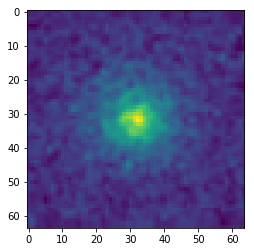

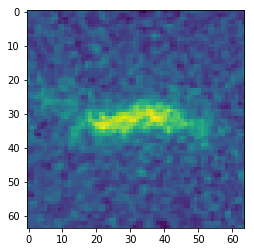

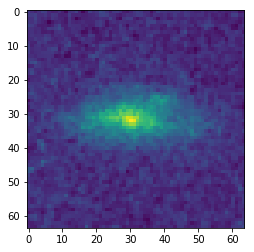

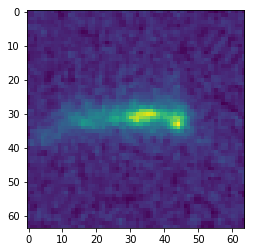

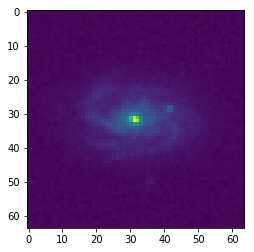

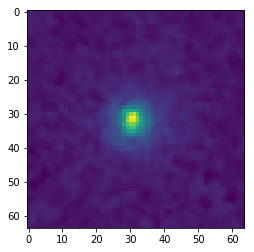

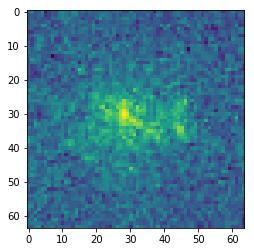

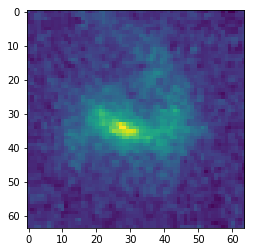

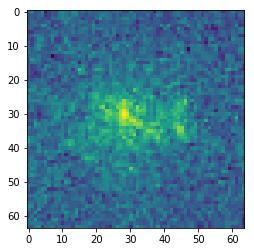

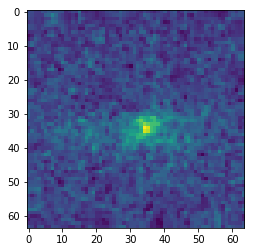

In [10]:
import random as rnd

filename = 'COSMOS_FULL.hdf5'
f = h5py.File(filename, 'r')
print(list(f.keys()))

# Get the data
for i in range(10):
    j = rnd.randint(0,100)
    plt.imshow(f['images'][j])
    plt.show()